In [3]:
# !pip install -qr "../requirements.txt"
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 6.0 MB/s eta 0:00:0000:0100:01


In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../')

# Load data

## Load data - Demonstration

In [2]:
df = pd.read_csv('../data/drive-me-not/trace1.csv')
# benign_flight.info()

#filter out the anchor points
df = df[df['Anchor_Number'] == 0]
df

,GPS_lat,GPS_long,Network_lat,Network_long,Time,Anchor_Number,Type,Registered,CID,LAC,MCC,MNC,dBm,level
0,25.328347,51.425060,0.0,0.0,1561278474631,0,GSM,True,23733,9301,427,1,-45,4
14,25.328347,51.425060,0.0,0.0,1561278474768,0,GSM,True,23733,9301,427,1,-45,4
28,25.328347,51.425060,0.0,0.0,1561278474932,0,GSM,True,23733,9301,427,1,-45,4
42,25.328347,51.425060,0.0,0.0,1561278475082,0,GSM,True,23733,9301,427,1,-45,4
56,25.328347,51.425060,0.0,0.0,1561278475263,0,GSM,True,23733,9301,427,1,-45,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34038,25.331563,51.421738,0.0,0.0,1561280145472,0,GSM,True,24882,9301,427,1,-57,4
34050,25.331563,51.421738,0.0,0.0,1561280155660,0,GSM,True,14792,150,427,2,-37,4
34057,25.331563,51.421738,0.0,0.0,1561280155829,0,GSM,True,24882,9301,427,1,-53,4
34070,25.331563,51.421738,0.0,0.0,1561280156156,0,GSM,True,24882,9301,427,1,-53,4


In [3]:
import pandasql as ps

# Filter out the rows whose change of position is not reflected in the coordinates
stmt = """SELECT * 
FROM df
WHERE Time in (
    SELECT min(Time) 
    FROM df
    GROUP BY GPS_lat, GPS_long 
    )
"""

df = ps.sqldf(stmt, locals())

In [12]:
from utils.haversine import haversine_component_distance

haversine_dist_lat, haversine_dist_lon = [], []

for rows in range(1, len(df)):
    dist =  haversine_component_distance(
        (df.loc[rows-1, 'GPS_lat'], df.loc[rows-1, 'GPS_long']), 
        (df.loc[rows, 'GPS_lat'], df.loc[rows, 'GPS_long'])
        )
    haversine_dist_lat.append(dist[0])
    haversine_dist_lon.append(dist[1])
    
pd.Series(haversine_dist_lat) / df.Time.diff().dropna().reset_index(drop=True)
pd.Series(haversine_dist_lon) / df.Time.diff().dropna().reset_index(drop=True)

0      0.000072
1      0.000057
2      0.000052
3      0.000081
4      0.000084
         ...   
527    0.000358
528    0.000111
529    0.001318
530    0.000291
531    0.000167
Length: 532, dtype: float64

In [19]:
df['vx'] = pd.Series(haversine_dist_lat) / df.Time.diff().dropna().reset_index(drop=True)
df['vy'] = pd.Series(haversine_dist_lon) / df.Time.diff().dropna().reset_index(drop=True)
df.dropna(inplace=True)

# compute acceleration
df['ax'] = df.vx.diff() / df.Time.diff()
df['ay'] = df.vy.diff() / df.Time.diff()
df.dropna(inplace=True)

,GPS_lat,GPS_long,Network_lat,Network_long,Time,Anchor_Number,Type,Registered,CID,LAC,MCC,MNC,dBm,level,vx,vy
0,25.328347,51.425060,0.0,0.0,1561278474631,0,GSM,1,23733,9301,427,1,-45,4,0.000039,0.000072
1,25.328332,51.425088,0.0,0.0,1561278477081,0,GSM,1,23733,9301,427,1,-45,4,0.000128,0.000057
2,25.328313,51.425080,0.0,0.0,1561278477990,0,GSM,1,23733,9301,427,1,-45,4,0.000169,0.000052
3,25.328287,51.425072,0.0,0.0,1561278478996,0,GSM,1,23733,9301,427,1,-45,4,0.000197,0.000081
4,25.328255,51.425058,0.0,0.0,1561278480021,0,GSM,1,23733,9301,427,1,-45,4,0.000365,0.000084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,25.331425,51.421340,0.0,0.0,1561280133158,0,GSM,1,22223,9301,427,1,-59,4,0.000207,0.000111
529,25.331608,51.421440,0.0,0.0,1561280138810,0,GSM,1,22223,9301,427,1,-59,4,0.000991,0.001318
530,25.331632,51.421472,0.0,0.0,1561280138960,0,GSM,1,22223,9301,427,1,-59,4,0.000076,0.000291
531,25.331563,51.421738,0.0,0.0,1561280144675,0,GSM,1,24882,9301,427,1,-57,4,0.000116,0.000167


In [29]:
from utils.preprocessing import zero_one_normalization

# compute velocity
df['vx'] = df.GPS_long.diff() / df.Time.diff()
df['vy'] = df.GPS_lat.diff() / df.Time.diff()
df.dropna(inplace=True)

# compute acceleration
df['ax'] = df.vx.diff() / df.Time.diff()
df['ay'] = df.vy.diff() / df.Time.diff()
df.dropna(inplace=True)

# 0-1 normalization

for col in ['vx', 'vy', 'ax', 'ay']:
    df[col] = zero_one_normalization(df[col])

selected_attributes = ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'dBm']
df = df[selected_attributes]
df

,GPS_lat,GPS_long,Time,vx,vy,ax,ay,dBm
2,25.328313,51.425080,1561278477990,0.587335,0.702030,0.601616,0.809438,-45
3,25.328287,51.425072,1561278478996,0.587604,0.699785,0.602825,0.809960,-45
4,25.328255,51.425058,1561278480021,0.586167,0.698232,0.602545,0.810076,-45
5,25.328198,51.425045,1561278481009,0.586019,0.688861,0.602755,0.808792,-47
6,25.328133,51.425027,1561278481964,0.584285,0.685068,0.602475,0.809680,-47
...,...,...,...,...,...,...,...,...
528,25.331425,51.421340,1561280133158,0.607548,0.741344,0.602661,0.810040,-59
529,25.331608,51.421440,1561280138810,0.595506,0.720661,0.602422,0.809730,-59
530,25.331632,51.421472,1561280138960,0.654338,0.764265,0.668577,0.857162,-59
531,25.331563,51.421738,1561280144675,0.604317,0.704939,0.601312,0.808647,-57


In [5]:
from utils.visualization import plot_trace

plot_trace(df, mode="velocity")

## Pipelining the dataloader

In [6]:
from utils.preprocessing import data_preprocessing

traces = ['../data/drive-me-not/trace'+ str(i) + '.csv' for i in range(1, 9)]

traces_df = [data_preprocessing(trace, trace_num=i+1) for i, trace in enumerate(traces)]

for df in traces_df:
    print(df.shape)

(531, 7)
(564, 7)
(316, 7)
(463, 7)
(297, 7)
(393, 7)
(396, 7)
(318, 7)


## Malicious Data

In [52]:
a = [1,2,3]
b = [4,5,6]

c = [(i,j) for i, j in zip(a, b)]

for i, (j, k) in enumerate(c):
    print(i, j, k)


0 1 4
1 2 5
2 3 6


3

In [6]:
# trace 4 spoofed
from utils.preprocessing import data_preprocessing

# spoofed = pd.read_csv('../data/drive-me-not/trace4_spoofed.csv').drop(columns=['Unnamed: 0']).head()  


# estimated_trace4, trace4_spoofed 
# spoofed_4 = data_preprocessing('../data/drive-me-not/processed/trace4_spoofed.csv', 
#                              selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
#                              trace_num=4)

TRACE = 1

spoofed_data = data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(TRACE)+'.csv', 
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                             trace_num=TRACE)
benign_data = data_preprocessing('../data/drive-me-not/trace'+str(TRACE)+'.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=TRACE)
benign_data['spoofed'] = 0


from utils.visualization import plot_trace

x_range_s, y_range_s = (spoofed_data.GPS_lat.min(), 
         spoofed_data.GPS_lat.max()), \
        (spoofed_data.GPS_long.min(), 
         spoofed_data.GPS_long.max())
        
x_range_b, y_range_b = (benign_data.GPS_lat.min(), 
         benign_data.GPS_lat.max()), \
        (benign_data.GPS_long.min(), 
         benign_data.GPS_long.max())
        
x_range, y_range = (min(x_range_s[0], x_range_b[0]), 
                   max(x_range_s[1], x_range_b[1])), \
                  (min(y_range_s[0], y_range_b[0]), 
                   max(y_range_s[1], y_range_b[1]))

plot_trace(spoofed_data.iloc[:, :], 
           mode="velocity", 
           colored=True, marker_size=2,
           x_range=y_range, 
           y_range=x_range,
           )

# plot_trace(benign_data.iloc[:, :], 
#            mode="velocity", 
#            colored=True, marker_size=2,
#            x_range=y_range, 
#            y_range=x_range,
#            )

In [8]:
benign_4 = data_preprocessing('../data/drive-me-not/trace4.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=4)
benign_4['spoofed'] = 0
plot_trace(benign_4.iloc[:, :], 
        #    mode="velocity", 
           colored=True, marker_size=2)

# plot trace

In [2]:
from utils.preprocessing import data_preprocessing

spoofed_list = [data_preprocessing('../data/drive-me-not/spoofed/spoofed_trace'+str(trace)+'.csv', 
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay', 'spoofed'], 
                             trace_num=trace) for trace in range(1, 9)]
benign_list = [data_preprocessing('../data/drive-me-not/trace'+str(trace)+'.csv',
                             selected_attributes= ['GPS_lat', 'GPS_long', 'Time', 'vx', 'vy', 'ax', 'ay'], 
                             trace_num=trace) for trace in range(1, 9)]
for benign in benign_list:  
    benign['spoofed'] = 0
    
from utils.visualization import plot_spoofed_and_benign

plot_spoofed_and_benign(spoofed_list, benign_list, marker_size=2)

benign_list[0]

,GPS_lat,GPS_long,Time,vx,vy,ax,ay,trace,spoofed
1,25.328332,51.425088,1561278477081,0.010072,0.004713,0.976035,0.959217,1,0
2,25.328313,51.425080,1561278477990,0.013238,0.004259,0.976119,0.959217,1,0
3,25.328287,51.425072,1561278478996,0.015429,0.006688,0.975942,0.959629,1,0
4,25.328255,51.425058,1561278480021,0.028643,0.006939,0.977400,0.959323,1,0
5,25.328198,51.425045,1561278481009,0.033991,0.009870,0.976382,0.959707,1,0
...,...,...,...,...,...,...,...,...,...
527,25.330870,51.420990,1561280127048,0.045363,0.029437,0.975410,0.959168,1,0
528,25.331425,51.421340,1561280133158,0.016199,0.009091,0.974996,0.958817,1,0
529,25.331608,51.421440,1561280138810,0.077685,0.108470,0.977126,0.961773,1,0
530,25.331632,51.421472,1561280138960,0.005971,0.023974,0.910602,0.879686,1,0


# PCA preprocessing

In [9]:
# union all the traces
df_processed_with_trace = pd.concat(traces_df)


trace_num = df_processed_with_trace['trace'].astype("int")

# # exclude trace 4 for testing
# df_processed_without_4 = df_processed_with_trace[df_processed_with_trace['trace'] != 4]
# df_processed = df_processed_without_4.drop(columns=['trace'])

# # Donot exclude trace 4 for testing
df_processed = df_processed_with_trace.drop(columns=['trace'])


# standard scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_processed)
df_processed = pd.DataFrame(scaler.transform(df_processed), columns=df_processed.columns)

trace_num.reset_index(drop=True, inplace=True)

# pca transformation
from utils.preprocessing import pca_transform

N_COMPONENTS = 3

df_train, pca_train = pca_transform(df_processed, n_components=N_COMPONENTS)
df_train['trace'] = trace_num
df_train

,pca-one,pca-two,pca-three,trace
0,0.706322,0.564971,0.519280,1
1,0.706343,0.565724,0.517880,1
2,0.705644,0.565487,0.517052,1
3,0.703305,0.567606,0.511620,1
4,0.702291,0.567615,0.509598,1
...,...,...,...,...
3273,0.394640,0.244148,0.619074,8
3274,0.696949,0.607315,0.498106,8
3275,0.684969,0.587783,0.511861,8
3276,0.693821,0.583360,0.528489,8


## process the spoofed data

In [10]:
fields_for_pca = ['GPS_lat', 'GPS_long', 'vx', 'vy', 'ax', 'ay']

# standard scaling
spoofed_4_scaled = pd.DataFrame(scaler.transform(spoofed_4[fields_for_pca]), columns=spoofed_4[fields_for_pca].columns)

spoofed_pca = pca_train.transform(spoofed_4_scaled)

spoofed_for_test = pd.DataFrame(spoofed_pca, columns=['pca-one', 'pca-two', 'pca-three'])
spoofed_for_test['label'] = spoofed_4.spoofed.reset_index()['spoofed']
spoofed_for_test.label[1]

0

## legacy code

In [11]:
# # pca
# from utils.preprocessing import pca_transform, add_traces

# N_COMPONENTS = 3

# pca_dfs = [add_traces(df=pca_transform(df, n_components=N_COMPONENTS), num=i+1) for i, df in enumerate(traces_df)]

# pca_dfs = pd.concat(pca_dfs)
# pca_dfs['trace'] = pca_dfs['trace'].astype(int).astype(str)
# pca_dfs.reset_index(drop=True, inplace=True)
# pca_dfs

## visualize pca results

In [12]:
from utils.visualization import plot_pca

plot_pca(df_train, n_components=N_COMPONENTS)

# One-class Classification

## OCSVM

One-class SVM

In [16]:
df_train_svm = df_train[['pca-one', 'pca-two', 'pca-three']]

In [69]:
from models.ocsvm import optimize_OneClassSVM

nu_opt, gamma_opt = optimize_OneClassSVM(df_train_svm, 20)

nu_opt, gamma_opt

Searching for optimal hyperparameters...
Found: nu = 0.5421052631578948, gamma = 0.0036848421052631582


(0.5421052631578948, 0.0036848421052631582)

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          -1    0.49784   1.00000   0.66474       230
           1    0.00000   0.00000   0.00000       232

    accuracy                        0.49784       462
   macro avg    0.24892   0.50000   0.33237       462
weighted avg    0.24784   0.49784   0.33093       462



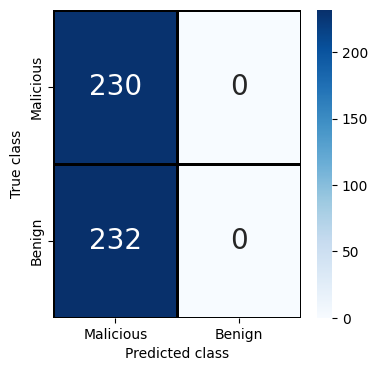

In [22]:
import pickle
from sklearn.svm import OneClassSVM
from sklearn import metrics
from utils.visualization import plot_cf_matrix

nu = 0.5421052631578948
gamma = 0.0036848421052631582

model = OneClassSVM(nu=nu, kernel="rbf", gamma = gamma)
model.fit(df_train_svm.values)

with open(f'../saved_models/pca_ocsvm/ocsvm_nu_{nu}_gamma_{gamma}.pkl', 'wb') as file:
    pickle.dump(model, file)

# change label to match oc svm
label_ocsvm = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
spoofed_for_test['label_ocsvm'] = label_ocsvm
 
y_pred = model.predict(spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values)
y_true = spoofed_for_test.label_ocsvm

print(metrics.classification_report(y_true, y_pred, digits=5))
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
plot_cf_matrix(conf_matrix)

## Local Outlier Factor (LOF)

### lof data preparation

In [9]:
df_train_lof = df_train[['pca-one', 'pca-two', 'pca-three']]
df_train_lof

,pca-one,pca-two,pca-three
0,0.706322,0.564971,0.519280
1,0.706343,0.565724,0.517880
2,0.705644,0.565487,0.517052
3,0.703305,0.567606,0.511620
4,0.702291,0.567615,0.509598
...,...,...,...
3273,0.394640,0.244148,0.619074
3274,0.696949,0.607315,0.498106
3275,0.684969,0.587783,0.511861
3276,0.693821,0.583360,0.528489


In [10]:
label_lof = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
spoofed_for_test['label_lof'] = label_lof
spoofed_for_test

,pca-one,pca-two,pca-three,label,label_lof
0,-1.439346,4.153807,-0.866847,0,1
1,-1.395856,4.423392,-1.049596,0,1
2,-1.970696,3.556558,-0.702043,0,1
3,-1.907315,3.772671,-0.837110,0,1
4,-1.791436,3.978190,-0.942015,0,1
...,...,...,...,...,...
457,-1.314267,3.212300,-2.362250,1,-1
458,-1.335627,3.184107,-2.359143,1,-1
459,-1.456717,3.033321,-2.332215,1,-1
460,-1.327511,3.180854,-2.377327,1,-1


### train lof

In [23]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_recall_fscore_support as score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns

from utils.visualization import plot_cf_matrix
from models.lof import optimize_LocalOutlierFactor

neighbor_opt, fscore = optimize_LocalOutlierFactor(
    df_train_lof, 
    spoofed_for_test, 
    neighbors_arange=(10,3000,100)
    )
    
print("Highest acheived macro average F1 was %f using %f neighbours" % (fscore, neighbor_opt))
print(metrics.classification_report(y_true, y_pred, digits=5))
print(conf_matrix)

Highest acheived macro average F1 was 0.332370 using 10.000000 neighbours
              precision    recall  f1-score   support

          -1    0.49784   1.00000   0.66474       230
           1    0.00000   0.00000   0.00000       232

    accuracy                        0.49784       462
   macro avg    0.24892   0.50000   0.33237       462
weighted avg    0.24784   0.49784   0.33093       462

[[230   0]
 [232   0]]


/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/Caskroom/miniconda/base/envs/newbase/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



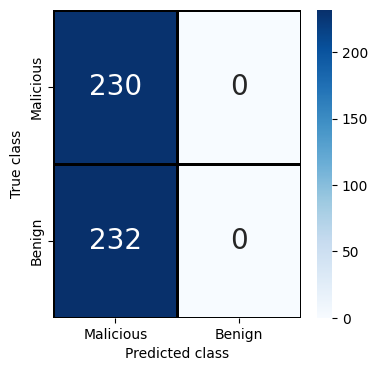

In [13]:
plot_cf_matrix(conf_matrix)

## Autoencoder

An Autoencoder Neural Network works by taking input, compressing it and trying to *reproduce the same input*. It is trained on a benign dataset using MSE. 

**Threshold**: If the MSE of the reconstructed output is over a delta threshold, 𝑇, it is classified as a novelty.
The paper did not tell us how to pick the proper threshold.

In [13]:
df_train_ae = df_train.drop(columns=['trace'])

### Autoencoder data preparation

In [22]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df_train_ae, df_train_ae, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# turn to tensor
autoencoder_X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
autoencoder_y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
autoencoder_X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
autoencoder_y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
autoencoder_X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
autoencoder_y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

# create TensorDataset
autoencoder_train_dataset = TensorDataset(autoencoder_X_train_tensor, autoencoder_y_train_tensor)
autoencoder_test_dataset = TensorDataset(autoencoder_X_test_tensor, autoencoder_y_test_tensor)
autoencoder_val_dataset = TensorDataset(autoencoder_X_val_tensor, autoencoder_y_val_tensor)

### Autoencoder Training

Monitor on wandb 

In [ ]:
df_train, pca_train

from models.autoencoder import Autoencoder
from utils.trainer import Trainer
from sklearn.model_selection import train_test_split

FIRST_LAYER_SIZE = 25
HIDDEN_SIZE = 3
LAST_LAYER_SIZE = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 100

# creare Dataloader
autoencoder_train_dataloader = DataLoader(autoencoder_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder_test_dataloader = DataLoader(autoencoder_test_dataset, batch_size=BATCH_SIZE, shuffle=True)
autoencoder_val_dataloader = DataLoader(autoencoder_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

autoencoder_model = Autoencoder(input_size=N_COMPONENTS,
                                first_layer_size= FIRST_LAYER_SIZE,
                                hidden_size= HIDDEN_SIZE,
                                last_layer_size= LAST_LAYER_SIZE,
                                output_size= N_COMPONENTS,
                                )

autoencoder_criterion = torch.nn.MSELoss()
#adam optimizer
autoencoder_optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)

autoencoder_trainer = Trainer(model=autoencoder_model, 
                              train_loader=autoencoder_train_dataloader,
                              val_loader=autoencoder_val_dataloader,
                              criterion=autoencoder_criterion,
                              optimizer=autoencoder_optimizer,
                              if_wandb=True,
                              wandb_project_name="autoencoder",)

autoencoder_trainer.train(epochs=EPOCHS)

## raytune

### autoencoder model

In [ ]:

# self-defined autoencoder model

import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

N_COMPONENTS = 3

class Autoencoder(nn.Module):
    """
    Autoencoder class

    Parameters
    ----------
    nn : _type_
        _description_
    """
    
    def __init__(self, input_size=N_COMPONENTS, 
                 first_layer_size=25, 
                 hidden_size=3, 
                 last_layer_size=25, 
                 output_size=N_COMPONENTS,
                 **kwargs):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, first_layer_size),
            nn.ReLU(True),
            nn.Linear(first_layer_size, hidden_size),
            nn.ReLU(True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, last_layer_size),
            nn.ReLU(True),
            nn.Linear(last_layer_size, output_size),
            nn.Sigmoid()
            )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
    
def predict_spoofed(y_pred, spoofed_ae, T) -> list:
    """ 
    Predict spoofed data using the autoencoder model, over a threshold T.
    """
    
    spoofed_pred = []
    
    for y_p, s_t in zip(y_pred, spoofed_ae):
        
        mse = mean_squared_error(y_p, s_t)
        if mse > T:
            # larger than threshold, spoofed
            spoofed_pred.append(-1)
        else:
            # smaller than threshold, benign
            spoofed_pred.append(1)
            
    return spoofed_pred

### define function

In [22]:
from models import autoencoder 
import tqdm

def ray_trainer(config, df_train_ae):
    
    model = Autoencoder(hidden_size=config['hidden_size'])
    
    
    
    
    from torch.utils.data import TensorDataset
    from sklearn.model_selection import train_test_split

    X_train, X_temp, y_train, y_temp = train_test_split(df_train_ae, df_train_ae, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # turn to tensor
    autoencoder_X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    autoencoder_y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    autoencoder_X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    autoencoder_y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    autoencoder_X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    autoencoder_y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

    # create TensorDataset
    autoencoder_train_dataset = TensorDataset(autoencoder_X_train_tensor, autoencoder_y_train_tensor)
    autoencoder_test_dataset = TensorDataset(autoencoder_X_test_tensor, autoencoder_y_test_tensor)
    autoencoder_val_dataset = TensorDataset(autoencoder_X_val_tensor, autoencoder_y_val_tensor)
    
    train_loader = DataLoader(autoencoder_train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(autoencoder_test_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(autoencoder_val_dataset, batch_size=config['batch_size'], shuffle=True)


    criterion = torch.nn.MSELoss()
    #adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    

        
    def train_epoch():
        
        running_loss = 0.0
        
        # print progress bar using tqdm, only when epoch % 10 == 0
        
        for i, data in tqdm.tqdm(enumerate(train_loader), 
                                    total=len(train_loader),
                                    leave=True,
                                    ):
            
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # Convert to float
            inputs, labels = inputs.float(), labels.float()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            loss.backward()
            
            # Update model parameters
            optimizer.step()
            
            running_loss += loss.item()         


        print(f"Train Loss: {running_loss}")
    
        return running_loss
             
                
    def validate_epoch():
        """Execute validation process for one epoch."""
        # forward pass
        model.eval()
        
        val_loss = 0.0
        
        with torch.no_grad():
            for i, data in tqdm.tqdm(enumerate(val_loader), 
                                        total=len(val_loader),
                                        leave=True,
                                        ):
                inputs, labels = data
                inputs, labels = inputs.float(), labels.float()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()

            
        model.train()
        
        return val_loss
    
    
    train_loss = []
    val_loss = []
    
    epochs = 100
    
    for epoch in range(epochs):
        
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss.append(train_epoch())
        val_loss.append(validate_epoch())

    print("Finished Training")    
    return {"train_loss": train_loss[-1], "val_loss": val_loss[-1]}
    


### raytune train

In [23]:
from ray import tune
import ray
from functools import partial

import sys
sys.path.append('../')
# from utils.trainer import ray_trainer


trial_space = {
    # This is an example parameter. You could replace it with filesystem paths,
    # model types, or even full nested Python dicts of model configurations, etc.,
    # that enumerate the set of trials to run.
    "lr": tune.grid_search([0.001, 0.01, 0.1]),
    "batch_size": tune.grid_search([32, 64]),
    "hidden_size": tune.grid_search([3, 6]),
}

train_function = partial(ray_trainer, df_train_ae=df_train_ae)

train_model = tune.with_resources(train_function, {"cpu": 1})

tuner = tune.Tuner(train_function, param_space=trial_space)
results = tuner.fit()

2024-06-15 03:29:40,859	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/keniwo/ray_results/ray_trainer_2024-06-15_03-29-20' in 0.0126s.
2024-06-15 03:29:40,863	INFO tune.py:1041 -- Total run time: 20.31 seconds (20.28 seconds for the tuning loop).


In [26]:
results.get_best_result(metric="val_loss", mode="min", scope="last")

Result(
  metrics={'train_loss': 0.0016989600480883382, 'val_loss': 0.00023566579329781234},
  path='/Users/keniwo/ray_results/ray_trainer_2024-06-15_03-29-20/ray_trainer_b0831_00003_3_batch_size=64,hidden_size=6,lr=0.0010_2024-06-15_03-29-20',
  filesystem='local',
  checkpoint=None
)

### Tests

In [26]:
#save model
autoencoder_trainer.save_model(path = f'../saved_models/pca_autoencoder/autoencoder.pth')

In [27]:
# test model on autoencoder_test_dataloader

autoencoder_trainer.model.eval()

losses = []

for i, (x, y) in enumerate(autoencoder_test_dataloader):
    y_pred = autoencoder_trainer.model(x)
    loss = autoencoder_trainer.criterion(y_pred, y)
    losses.append(loss.item())
    
print(f"Average loss on test set: {np.mean(losses)}")

Average loss on test set: 9.767855021891592e-05


### Use Autoencoder to detect spoofing by a Threshold $T$

In [28]:
label_ae = spoofed_for_test.label.apply(lambda x: 1 if x == 0 else -1)
spoofed_for_test['label_ocsvm'] = label_ae
spoofed_ae = spoofed_for_test[['pca-one', 'pca-two', 'pca-three']].values

In [30]:
autoencoder_trainer.model.eval()
y_pred = autoencoder_trainer.model(torch.tensor(spoofed_ae, dtype=torch.float32)).detach().numpy()
y_pred.shape

(462, 3)

Search for a ideal T

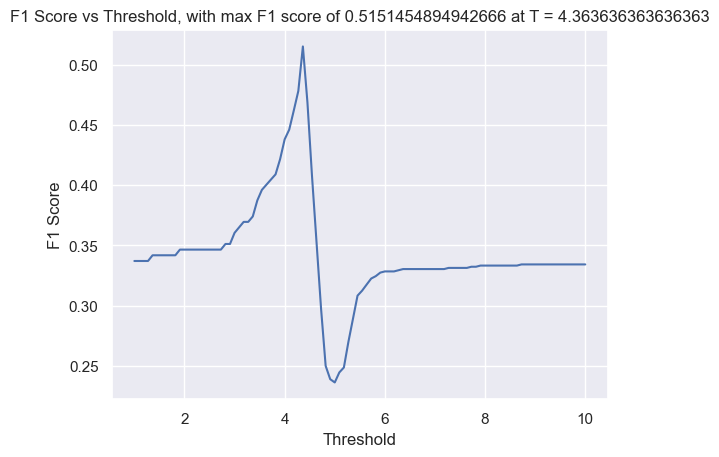

In [75]:
from sklearn.metrics import mean_squared_error
from models.autoencoder import predict_spoofed
from sklearn import metrics
from matplotlib import pyplot as plt

f1_list = []
cf_matrix_list = []
T_range = np.linspace(1, 10, 100)
max_f1 = 0

for T in T_range:
    spoofed_pred = predict_spoofed(y_pred, spoofed_ae, T)
    y_true = spoofed_for_test.label_ocsvm
    
    metrics.confusion_matrix(y_true, spoofed_pred)
    cf_matrix_list.append(
        metrics.confusion_matrix(y_true, spoofed_pred)
        )
    
    _, _, f1_score_ae, _ = score(y_true, spoofed_pred, average='macro', zero_division=1)
    
    max_f1 = max(max_f1, f1_score_ae)
    f1_list.append(f1_score_ae)

sns.set_theme(context='notebook', style='darkgrid')
plt.plot(T_range, f1_list)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title(f'F1 Score vs Threshold, with max F1 score of {max_f1} at T = {T_range[np.argmax(f1_list)]}')
plt.savefig(f'../outputs/img/autoencoder_f1_vs_threshold_T_{T_range[np.argmax(f1_list)]}.png')